In [1]:
# code for task 2.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Load data
file_path = "/Users/ethanbensadoun/Desktop/LSE/ST443 Machine Learning and Data Mining/project/data-2.csv.gz"
data = pd.read_csv(file_path, compression='gzip')
X = data.drop('label', axis=1).values
y = data['label'].values

print(f"Data shape: {X.shape}")
print(f"Class distribution: Left={np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%), "
      f"Right={np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Feature counts to evaluate
feature_counts = [5, 10, 20, 50, 100, 200, 500, 1000]

print("\n" + "="*70)
print("STARTING TASK 2.2: THREE METHODS FROM COURSE")
print("="*70)

/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Data shape: (683, 11190)
Class distribution: Left=208 (30.5%), Right=475 (69.5%)
Standardizing features...

STARTING TASK 2.2: THREE METHODS FROM COURSE


In [2]:
#############################################################################
# METHOD 1: L1-Regularized Logistic Regression (Lasso)
#############################################################################

print("\n" + "="*70)
print("METHOD 1: L1-Regularized Logistic Regression (Lasso)")
print("="*70)

def evaluate_l1_logistic_selection(X, y, k, cv):
    """
    L1-regularized logistic regression for feature selection
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Tune C to get approximately k features
        C_value = 0.01 if k < 100 else 0.1 if k < 500 else 1.0
        
        # L1 logistic regression
        l1_model = LogisticRegression(
            penalty='l1',
            solver='liblinear',
            C=C_value,
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        )
        l1_model.fit(X_train, y_train)
        
        # Select top k features by absolute coefficient
        coef_abs = np.abs(l1_model.coef_[0])
        top_k_idx = np.argsort(coef_abs)[-k:]
        
        X_train_selected = X_train[:, top_k_idx]
        X_val_selected = X_val[:, top_k_idx]
        
        # Train final classifier on selected features
        clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        clf.fit(X_train_selected, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_val_selected)
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        scores.append(bal_acc)
    
    return np.mean(scores), np.std(scores)

# Run Method 1
start_time = time.time()
l1_results = []

for k in feature_counts:
    if k <= X.shape[1]:
        mean_acc, std_acc = evaluate_l1_logistic_selection(X_scaled, y, k, cv)
        l1_results.append({'n_features': k, 'bal_acc': mean_acc, 'std': std_acc})
        print(f"  k={k:4d}: Balanced Acc = {mean_acc:.4f} ± {std_acc:.4f}")

elapsed = time.time() - start_time
print(f"\nMethod 1 completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

l1_df = pd.DataFrame(l1_results)

#############################################################################
# METHOD 2: Random Forest Feature Importance
#############################################################################

print("\n" + "="*70)
print("METHOD 2: Random Forest Feature Importance")
print("="*70)

def evaluate_rf_selection(X, y, k, cv):
    """
    Random Forest feature importance for feature selection
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train Random Forest with class balancing
        rf = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        # Select top k features by importance
        importances = rf.feature_importances_
        top_k_idx = np.argsort(importances)[-k:]
        
        X_train_selected = X_train[:, top_k_idx]
        X_val_selected = X_val[:, top_k_idx]
        
        # Train final classifier on selected features
        clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        clf.fit(X_train_selected, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_val_selected)
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        scores.append(bal_acc)
    
    return np.mean(scores), np.std(scores)

# Run Method 2
start_time = time.time()
rf_results = []

for k in feature_counts:
    if k <= X.shape[1]:
        mean_acc, std_acc = evaluate_rf_selection(X_scaled, y, k, cv)
        rf_results.append({'n_features': k, 'bal_acc': mean_acc, 'std': std_acc})
        print(f"  k={k:4d}: Balanced Acc = {mean_acc:.4f} ± {std_acc:.4f}")

elapsed = time.time() - start_time
print(f"\nMethod 2 completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

rf_df = pd.DataFrame(rf_results)

#############################################################################
# METHOD 3: F-statistic Filter
#############################################################################

print("\n" + "="*70)
print("METHOD 3: F-statistic Filter (Univariate Feature Selection)")
print("="*70)

def evaluate_fstat_selection(X, y, k, cv):
    """
    F-statistic filter method for feature selection
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # F-statistic filter
        selector = SelectKBest(f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_val_selected = selector.transform(X_val)
        
        # Train classifier on selected features
        clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        clf.fit(X_train_selected, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_val_selected)
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        scores.append(bal_acc)
    
    return np.mean(scores), np.std(scores)

# Run Method 3
start_time = time.time()
fstat_results = []

for k in feature_counts:
    if k <= X.shape[1]:
        mean_acc, std_acc = evaluate_fstat_selection(X_scaled, y, k, cv)
        fstat_results.append({'n_features': k, 'bal_acc': mean_acc, 'std': std_acc})
        print(f"  k={k:4d}: Balanced Acc = {mean_acc:.4f} ± {std_acc:.4f}")

elapsed = time.time() - start_time
print(f"\nMethod 3 completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

fstat_df = pd.DataFrame(fstat_results)

print("\n" + "="*70)
print("TASK 2.2 COMPLETED")
print("="*70)


METHOD 1: L1-Regularized Logistic Regression (Lasso)
  k=   5: Balanced Acc = 0.5056 ± 0.0444
  k=  10: Balanced Acc = 0.5236 ± 0.0141
  k=  20: Balanced Acc = 0.4866 ± 0.0226
  k=  50: Balanced Acc = 0.5336 ± 0.0414
  k= 100: Balanced Acc = 0.7393 ± 0.0201
  k= 200: Balanced Acc = 0.7219 ± 0.0409
  k= 500: Balanced Acc = 0.7387 ± 0.0294
  k=1000: Balanced Acc = 0.7171 ± 0.0227

Method 1 completed in 15.2 seconds (0.3 minutes)

METHOD 2: Random Forest Feature Importance
  k=   5: Balanced Acc = 0.6038 ± 0.0441
  k=  10: Balanced Acc = 0.6293 ± 0.0566
  k=  20: Balanced Acc = 0.6824 ± 0.0417
  k=  50: Balanced Acc = 0.7177 ± 0.0276
  k= 100: Balanced Acc = 0.7039 ± 0.0188
  k= 200: Balanced Acc = 0.6901 ± 0.0488
  k= 500: Balanced Acc = 0.6899 ± 0.0487
  k=1000: Balanced Acc = 0.7290 ± 0.0351

Method 2 completed in 13.3 seconds (0.2 minutes)

METHOD 3: F-statistic Filter (Univariate Feature Selection)


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k=   5: Balanced Acc = 0.6213 ± 0.0380


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k=  10: Balanced Acc = 0.6357 ± 0.0499


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k=  20: Balanced Acc = 0.6854 ± 0.0322


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k=  50: Balanced Acc = 0.7020 ± 0.0439


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k= 100: Balanced Acc = 0.7232 ± 0.0276


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k= 200: Balanced Acc = 0.7128 ± 0.0547


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k= 500: Balanced Acc = 0.7314 ± 0.0198


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    8    14    50    60   130   153   205   255   325   368   398   405
   453   459   467   468   470   543   553   554   645   678   693   708
   725   741   749   758   784   788   813   814   818   840   843   856
   917   925   961   992  1035  1038  1045  1058  1066  1069  1071  1072
  1075  1100  1102  1106  1108  1109  1112  1114  1127  1133  1169  1179
  1249  1272  1324  1374  1444  1487  1517  1524  1572  1578  1586  1587
  1589  1662  1672  1673  1764  1797  1812  1827  1844  1860  1868  1877
  1903  1907  1932  1933  1937  1959  1962  1975  2036  2044  2080  2111
  2154  2157  2164  2177  2185  2188  2190  2191  2194  2219  2221  2225
  2227  2228  2231  2233  2252  2288  2298  2368  2393  2401  2443  2528
  2563  2643  2675  2697  2706  2708  2791  2792  2839  2906  2916  2931
  2938  2946  2961  2963  2979  2987  2996  3022  3026  30

  k=1000: Balanced Acc = 0.7152 ± 0.0271

Method 3 completed in 5.7 seconds (0.1 minutes)

TASK 2.2 COMPLETED


In [3]:
print("\n" + "="*70)
print("STARTING TASK 2.3: ADDITIONAL METHODS (NOT IN COURSE)")
print("="*70)

#############################################################################
# ADDITIONAL METHOD 1: Elastic Net
#############################################################################

print("\n" + "="*70)
print("ADDITIONAL METHOD 1: Elastic Net (L1 + L2 Combination)")
print("="*70)

from sklearn.linear_model import SGDClassifier

def evaluate_elastic_net_selection(X, y, k, cv):
    """
    Elastic Net (combines L1 and L2 penalties) for feature selection
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Elastic Net via SGD
        # Tune alpha to get approximately k features
        alpha = 0.0001 if k < 100 else 0.00001 if k < 500 else 0.000001
        
        elastic = SGDClassifier(
            loss='log_loss',
            penalty='elasticnet',
            alpha=alpha,
            l1_ratio=0.7,  # 70% L1, 30% L2
            class_weight='balanced',
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )
        elastic.fit(X_train, y_train)
        
        # Select top k features by absolute coefficient
        coef_abs = np.abs(elastic.coef_[0])
        top_k_idx = np.argsort(coef_abs)[-k:]
        
        X_train_selected = X_train[:, top_k_idx]
        X_val_selected = X_val[:, top_k_idx]
        
        # Train final classifier on selected features
        clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        clf.fit(X_train_selected, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_val_selected)
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        scores.append(bal_acc)
    
    return np.mean(scores), np.std(scores)

# Run Additional Method 1
start_time = time.time()
elastic_results = []

for k in feature_counts:
    if k <= X.shape[1]:
        mean_acc, std_acc = evaluate_elastic_net_selection(X_scaled, y, k, cv)
        elastic_results.append({'n_features': k, 'bal_acc': mean_acc, 'std': std_acc})
        print(f"  k={k:4d}: Balanced Acc = {mean_acc:.4f} ± {std_acc:.4f}")

elapsed = time.time() - start_time
print(f"\nElastic Net completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

elastic_df = pd.DataFrame(elastic_results)

#############################################################################
# ADDITIONAL METHOD 2: Mutual Information
#############################################################################

print("\n" + "="*70)
print("ADDITIONAL METHOD 2: Mutual Information (Information-Theoretic)")
print("="*70)

def evaluate_mi_selection(X, y, k, cv):
    """
    Mutual Information filter method for feature selection
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Mutual Information
        selector = SelectKBest(mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_val_selected = selector.transform(X_val)
        
        # Train classifier on selected features
        clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        clf.fit(X_train_selected, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_val_selected)
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        scores.append(bal_acc)
    
    return np.mean(scores), np.std(scores)

# Run Additional Method 2
start_time = time.time()
mi_results = []

for k in feature_counts:
    if k <= X.shape[1]:
        mean_acc, std_acc = evaluate_mi_selection(X_scaled, y, k, cv)
        mi_results.append({'n_features': k, 'bal_acc': mean_acc, 'std': std_acc})
        print(f"  k={k:4d}: Balanced Acc = {mean_acc:.4f} ± {std_acc:.4f}")

elapsed = time.time() - start_time
print(f"\nMutual Information completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

mi_df = pd.DataFrame(mi_results)

#############################################################################
# ADDITIONAL METHOD 3: Gradient Boosting Feature Importance (OPTIONAL)
#############################################################################

print("\n" + "="*70)
print("ADDITIONAL METHOD 3: Gradient Boosting Feature Importance (OPTIONAL)")
print("="*70)

def evaluate_gradient_boosting_selection(X, y, k, cv):
    """
    Gradient Boosting feature importance for feature selection
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Gradient Boosting with sample weights for imbalance
        scale_pos_weight = np.sum(y_train == 1) / np.sum(y_train == 0)
        sample_weights = np.ones(len(y_train))
        sample_weights[y_train == 0] = scale_pos_weight
        
        gb = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
        gb.fit(X_train, y_train, sample_weight=sample_weights)
        
        # Select top k features by importance
        importances = gb.feature_importances_
        top_k_idx = np.argsort(importances)[-k:]
        
        X_train_selected = X_train[:, top_k_idx]
        X_val_selected = X_val[:, top_k_idx]
        
        # Train final classifier on selected features
        clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        clf.fit(X_train_selected, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_val_selected)
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        scores.append(bal_acc)
    
    return np.mean(scores), np.std(scores)

# Run Additional Method 3
start_time = time.time()
gb_results = []

for k in feature_counts:
    if k <= X.shape[1]:
        mean_acc, std_acc = evaluate_gradient_boosting_selection(X_scaled, y, k, cv)
        gb_results.append({'n_features': k, 'bal_acc': mean_acc, 'std': std_acc})
        print(f"  k={k:4d}: Balanced Acc = {mean_acc:.4f} ± {std_acc:.4f}")

elapsed = time.time() - start_time
print(f"\nGradient Boosting completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

gb_df = pd.DataFrame(gb_results)

print("\n" + "="*70)
print("TASK 2.3 COMPLETED")
print("="*70)


STARTING TASK 2.3: ADDITIONAL METHODS (NOT IN COURSE)

ADDITIONAL METHOD 1: Elastic Net (L1 + L2 Combination)
  k=   5: Balanced Acc = 0.5898 ± 0.0183
  k=  10: Balanced Acc = 0.6160 ± 0.0378
  k=  20: Balanced Acc = 0.6491 ± 0.0488
  k=  50: Balanced Acc = 0.6620 ± 0.0544
  k= 100: Balanced Acc = 0.6622 ± 0.0328
  k= 200: Balanced Acc = 0.6940 ± 0.0575
  k= 500: Balanced Acc = 0.6767 ± 0.0402
  k=1000: Balanced Acc = 0.7040 ± 0.0438

Elastic Net completed in 22.0 seconds (0.4 minutes)

ADDITIONAL METHOD 2: Mutual Information (Information-Theoretic)
  k=   5: Balanced Acc = 0.5818 ± 0.0252
  k=  10: Balanced Acc = 0.5449 ± 0.0409
  k=  20: Balanced Acc = 0.5805 ± 0.0429
  k=  50: Balanced Acc = 0.6176 ± 0.0425
  k= 100: Balanced Acc = 0.6047 ± 0.0496
  k= 200: Balanced Acc = 0.6419 ± 0.0153
  k= 500: Balanced Acc = 0.6566 ± 0.0180
  k=1000: Balanced Acc = 0.6805 ± 0.0479

Mutual Information completed in 1234.3 seconds (20.6 minutes)

ADDITIONAL METHOD 3: Gradient Boosting Feature Impo


SUMMARY TABLES

----------------------------------------------------------------------
T2.2: METHODS FROM COURSE
----------------------------------------------------------------------
Method                              Best k     Balanced Acc        
----------------------------------------------------------------------
L1 Logistic Regression              100        0.7393 ± 0.0201
Random Forest Importance            1000       0.7290 ± 0.0351
F-statistic Filter                  500        0.7314 ± 0.0198

----------------------------------------------------------------------
T2.3: ADDITIONAL METHODS
----------------------------------------------------------------------
Method                              Best k     Balanced Acc        
----------------------------------------------------------------------
Elastic Net                         1000       0.7040 ± 0.0438
Mutual Information                  1000       0.6805 ± 0.0479
Gradient Boosting Importance        500        0.7631 

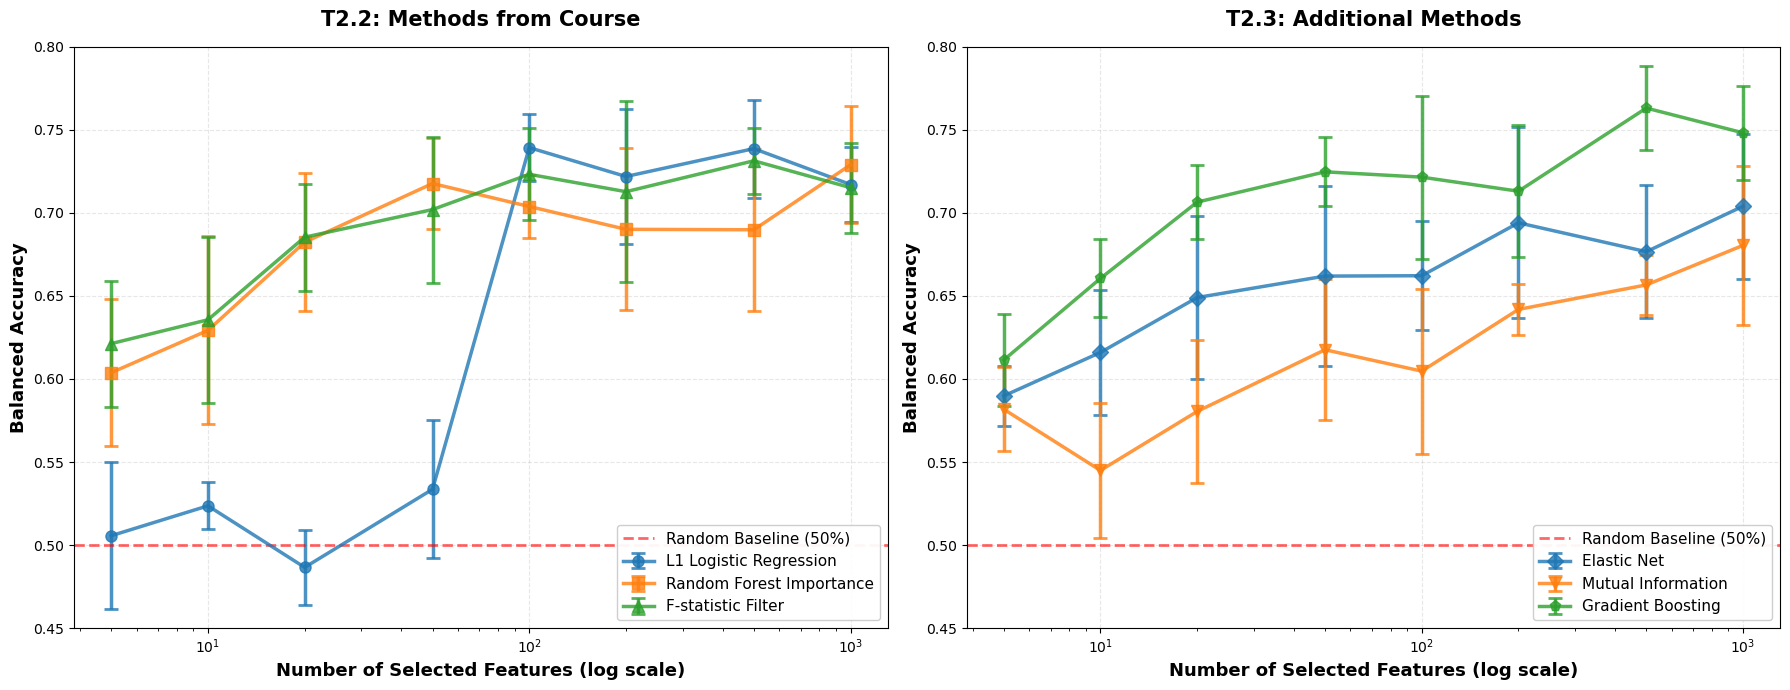

✗ Could not save combined figure (read-only filesystem)


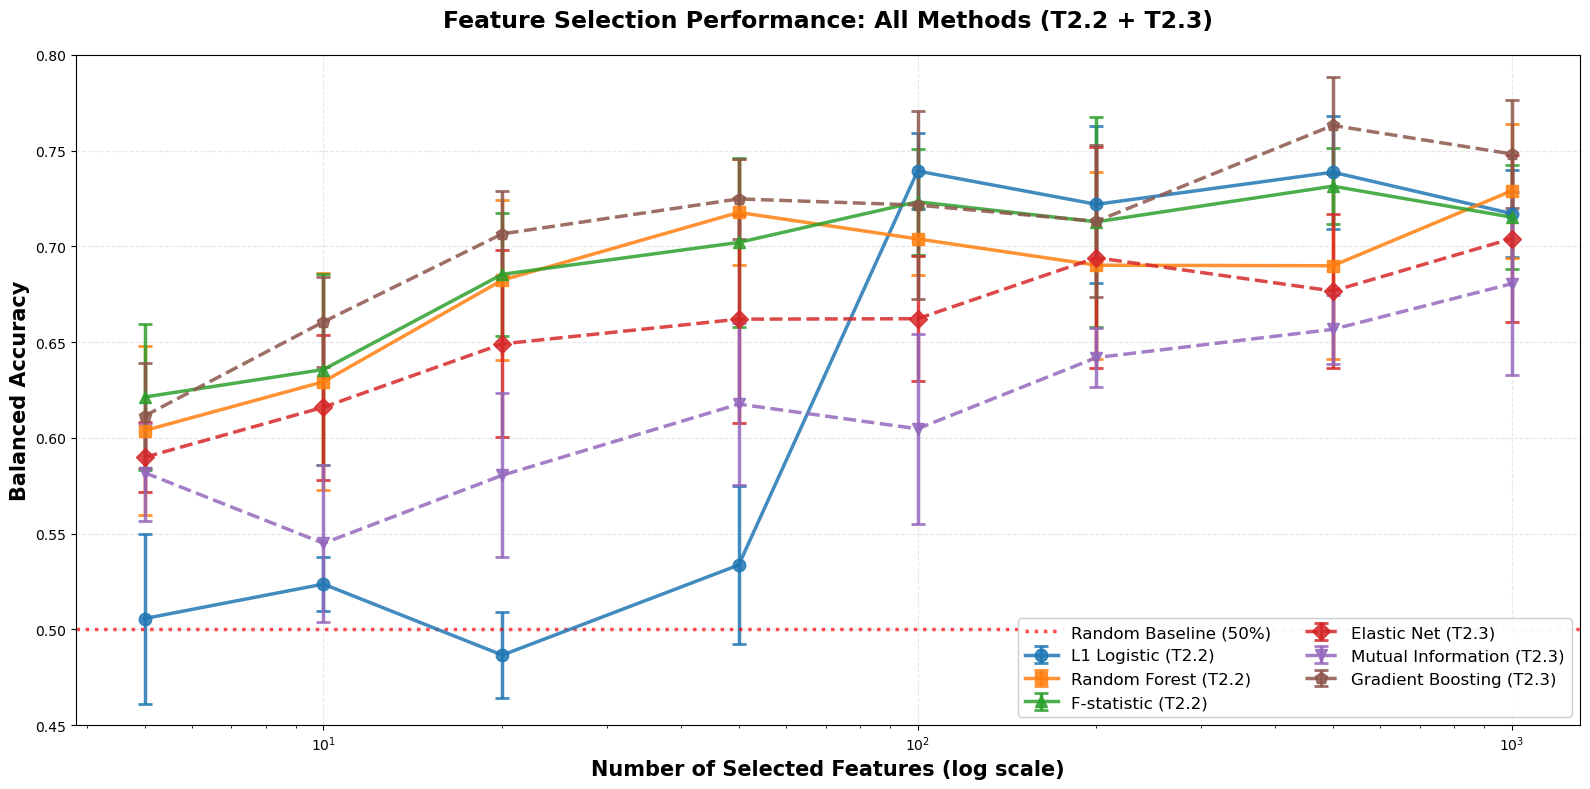


ALL ANALYSIS COMPLETED!


In [4]:
#############################################################################
# SUMMARY TABLES
#############################################################################

print("\n" + "="*70)
print("SUMMARY TABLES")
print("="*70)

# T2.2 Summary Table
print("\n" + "-"*70)
print("T2.2: METHODS FROM COURSE")
print("-"*70)
print(f"{'Method':<35} {'Best k':<10} {'Balanced Acc':<20}")
print("-"*70)

t22_methods = [
    ('L1 Logistic Regression', l1_df),
    ('Random Forest Importance', rf_df),
    ('F-statistic Filter', fstat_df)
]

for method_name, results_df in t22_methods:
    best_idx = results_df['bal_acc'].idxmax()
    best_k = results_df.loc[best_idx, 'n_features']
    best_acc = results_df.loc[best_idx, 'bal_acc']
    best_std = results_df.loc[best_idx, 'std']
    print(f"{method_name:<35} {int(best_k):<10} {best_acc:.4f} ± {best_std:.4f}")

# T2.3 Summary Table
print("\n" + "-"*70)
print("T2.3: ADDITIONAL METHODS")
print("-"*70)
print(f"{'Method':<35} {'Best k':<10} {'Balanced Acc':<20}")
print("-"*70)

t23_methods = [
    ('Elastic Net', elastic_df),
    ('Mutual Information', mi_df),
    ('Gradient Boosting Importance', gb_df)
]

for method_name, results_df in t23_methods:
    best_idx = results_df['bal_acc'].idxmax()
    best_k = results_df.loc[best_idx, 'n_features']
    best_acc = results_df.loc[best_idx, 'bal_acc']
    best_std = results_df.loc[best_idx, 'std']
    print(f"{method_name:<35} {int(best_k):<10} {best_acc:.4f} ± {best_std:.4f}")

# Detailed comparison table for report
print("\n" + "-"*70)
print("DETAILED RESULTS FOR REPORT (ALL METHODS)")
print("-"*70)
print(f"{'k':<8} {'L1 Log':<18} {'RF':<18} {'F-stat':<18} {'Elastic':<18} {'MI':<18} {'GB':<18}")
print("-"*110)

for i in range(len(feature_counts)):
    k = feature_counts[i]
    l1_acc = f"{l1_df.loc[i, 'bal_acc']:.4f}±{l1_df.loc[i, 'std']:.4f}"
    rf_acc = f"{rf_df.loc[i, 'bal_acc']:.4f}±{rf_df.loc[i, 'std']:.4f}"
    fs_acc = f"{fstat_df.loc[i, 'bal_acc']:.4f}±{fstat_df.loc[i, 'std']:.4f}"
    el_acc = f"{elastic_df.loc[i, 'bal_acc']:.4f}±{elastic_df.loc[i, 'std']:.4f}"
    mi_acc = f"{mi_df.loc[i, 'bal_acc']:.4f}±{mi_df.loc[i, 'std']:.4f}"
    gb_acc = f"{gb_df.loc[i, 'bal_acc']:.4f}±{gb_df.loc[i, 'std']:.4f}"
    
    print(f"{k:<8} {l1_acc:<18} {rf_acc:<18} {fs_acc:<18} {el_acc:<18} {mi_acc:<18} {gb_acc:<18}")

#############################################################################
# VISUALIZATION: COMBINED PLOT
#############################################################################

print("\n" + "="*70)
print("GENERATING PLOTS")
print("="*70)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# SUBPLOT 1: T2.2 Methods (from course)
ax1 = axes[0]

ax1.errorbar(l1_df['n_features'], l1_df['bal_acc'], yerr=l1_df['std'], 
             marker='o', markersize=8, label='L1 Logistic Regression', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)
ax1.errorbar(rf_df['n_features'], rf_df['bal_acc'], yerr=rf_df['std'], 
             marker='s', markersize=8, label='Random Forest Importance', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)
ax1.errorbar(fstat_df['n_features'], fstat_df['bal_acc'], yerr=fstat_df['std'], 
             marker='^', markersize=8, label='F-statistic Filter', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)

ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
            label='Random Baseline (50%)', alpha=0.6)

ax1.set_xscale('log')
ax1.set_xlabel('Number of Selected Features (log scale)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('T2.2: Methods from Course', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0.45, 0.80)

# SUBPLOT 2: T2.3 Additional Methods
ax2 = axes[1]

ax2.errorbar(elastic_df['n_features'], elastic_df['bal_acc'], yerr=elastic_df['std'], 
             marker='D', markersize=8, label='Elastic Net', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)
ax2.errorbar(mi_df['n_features'], mi_df['bal_acc'], yerr=mi_df['std'], 
             marker='v', markersize=8, label='Mutual Information', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)
ax2.errorbar(gb_df['n_features'], gb_df['bal_acc'], yerr=gb_df['std'], 
             marker='p', markersize=8, label='Gradient Boosting', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)

ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
            label='Random Baseline (50%)', alpha=0.6)

ax2.set_xscale('log')
ax2.set_xlabel('Number of Selected Features (log scale)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
ax2.set_title('T2.3: Additional Methods', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0.45, 0.80)

plt.tight_layout()

# Try to save
try:
    plt.savefig('task2_feature_selection_all_methods.png', dpi=300, bbox_inches='tight')
    print("✓ Figure saved as 'task2_feature_selection_all_methods.png'")
except:
    print("✗ Could not save figure (read-only filesystem)")

plt.show()

#############################################################################
# SINGLE COMBINED PLOT (ALL METHODS)
#############################################################################

plt.figure(figsize=(16, 8))

# T2.2 methods (solid lines)
plt.errorbar(l1_df['n_features'], l1_df['bal_acc'], yerr=l1_df['std'], 
             marker='o', markersize=9, label='L1 Logistic (T2.2)', 
             capsize=5, linewidth=2.5, capthick=2, linestyle='-', alpha=0.85)
plt.errorbar(rf_df['n_features'], rf_df['bal_acc'], yerr=rf_df['std'], 
             marker='s', markersize=9, label='Random Forest (T2.2)', 
             capsize=5, linewidth=2.5, capthick=2, linestyle='-', alpha=0.85)
plt.errorbar(fstat_df['n_features'], fstat_df['bal_acc'], yerr=fstat_df['std'], 
             marker='^', markersize=9, label='F-statistic (T2.2)', 
             capsize=5, linewidth=2.5, capthick=2, linestyle='-', alpha=0.85)

# T2.3 methods (dashed lines)
plt.errorbar(elastic_df['n_features'], elastic_df['bal_acc'], yerr=elastic_df['std'], 
             marker='D', markersize=9, label='Elastic Net (T2.3)', 
             capsize=5, linewidth=2.5, capthick=2, linestyle='--', alpha=0.85)
plt.errorbar(mi_df['n_features'], mi_df['bal_acc'], yerr=mi_df['std'], 
             marker='v', markersize=9, label='Mutual Information (T2.3)', 
             capsize=5, linewidth=2.5, capthick=2, linestyle='--', alpha=0.85)
plt.errorbar(gb_df['n_features'], gb_df['bal_acc'], yerr=gb_df['std'], 
             marker='p', markersize=9, label='Gradient Boosting (T2.3)', 
             capsize=5, linewidth=2.5, capthick=2, linestyle='--', alpha=0.85)

plt.axhline(y=0.5, color='red', linestyle=':', linewidth=2.5, 
            label='Random Baseline (50%)', alpha=0.7)

plt.xscale('log')
plt.xlabel('Number of Selected Features (log scale)', fontsize=15, fontweight='bold')
plt.ylabel('Balanced Accuracy', fontsize=15, fontweight='bold')
plt.title('Feature Selection Performance: All Methods (T2.2 + T2.3)', 
          fontsize=17, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='lower right', framealpha=0.95, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0.45, 0.80)
plt.tight_layout()

# Try to save
try:
    plt.savefig('task2_feature_selection_combined.png', dpi=300, bbox_inches='tight')
    print("✓ Combined figure saved as 'task2_feature_selection_combined.png'")
except:
    print("✗ Could not save combined figure (read-only filesystem)")

plt.show()

print("\n" + "="*70)
print("ALL ANALYSIS COMPLETED!")
print("="*70)

In [5]:
#############################################################################
# ADDITIONAL METHOD 1: L1-Regularized Linear SVM (NOT IN COURSE)
#############################################################################

print("\n" + "="*70)
print("ADDITIONAL METHOD 1: L1-Regularized Linear SVM")
print("="*70)

from sklearn.svm import LinearSVC

def evaluate_l1_svm_selection(X, y, k, cv):
    """
    L1-regularized Linear SVM for feature selection
    
    Uses hinge loss + L1 penalty (not covered in course, but natural
    extension of L1 logistic regression with different loss function)
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Tune C to get approximately k features
        C_value = 0.01 if k < 100 else 0.1 if k < 500 else 1.0
        
        try:
            # L1-regularized Linear SVM
            svm_l1 = LinearSVC(
                penalty='l1',
                loss='squared_hinge',  # Required for L1 penalty
                dual=False,            # Required for L1 penalty
                C=C_value,
                class_weight='balanced',
                max_iter=3000,
                random_state=42,
                tol=1e-4
            )
            svm_l1.fit(X_train, y_train)
            
            # Select top k features by absolute coefficient
            coef_abs = np.abs(svm_l1.coef_[0])
            top_k_idx = np.argsort(coef_abs)[-k:]
            
            X_train_selected = X_train[:, top_k_idx]
            X_val_selected = X_val[:, top_k_idx]
            
            # Train final classifier on selected features
            clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
            clf.fit(X_train_selected, y_train)
            
            # Evaluate
            y_pred = clf.predict(X_val_selected)
            bal_acc = balanced_accuracy_score(y_val, y_pred)
            scores.append(bal_acc)
            
        except Exception as e:
            # If convergence fails for this fold, skip
            print(f"    Warning: Fold failed (k={k}): {str(e)[:50]}")
            continue
    
    if len(scores) > 0:
        return np.mean(scores), np.std(scores)
    else:
        # If all folds failed, return baseline
        return 0.5, 0.0

# Run Additional Method 1
start_time = time.time()
l1_svm_results = []

for k in feature_counts:
    if k <= X.shape[1]:
        mean_acc, std_acc = evaluate_l1_svm_selection(X_scaled, y, k, cv)
        l1_svm_results.append({'n_features': k, 'bal_acc': mean_acc, 'std': std_acc})
        print(f"  k={k:4d}: Balanced Acc = {mean_acc:.4f} ± {std_acc:.4f}")

elapsed = time.time() - start_time
print(f"\nL1-SVM completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

l1_svm_df = pd.DataFrame(l1_svm_results)


ADDITIONAL METHOD 1: L1-Regularized Linear SVM
  k=   5: Balanced Acc = 0.6334 ± 0.0349
  k=  10: Balanced Acc = 0.6869 ± 0.0316
  k=  20: Balanced Acc = 0.6948 ± 0.0220
  k=  50: Balanced Acc = 0.7228 ± 0.0181
  k= 100: Balanced Acc = 0.7249 ± 0.0430
  k= 200: Balanced Acc = 0.6965 ± 0.0313


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  k= 500: Balanced Acc = 0.7175 ± 0.0341


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  k=1000: Balanced Acc = 0.7172 ± 0.0223

L1-SVM completed in 42.4 seconds (0.7 minutes)


/Users/ethanbensadoun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [7]:
#############################################################################
# VISUALIZATION: T2.3 Methods
#############################################################################

# SUBPLOT 2: T2.3 Additional Methods (UPDATED)
ax2 = axes[1]

ax2.errorbar(l1_svm_df['n_features'], l1_svm_df['bal_acc'], yerr=l1_svm_df['std'], 
             marker='D', markersize=8, label='L1-SVM', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)
ax2.errorbar(elastic_df['n_features'], elastic_df['bal_acc'], yerr=elastic_df['std'], 
             marker='v', markersize=8, label='Elastic Net', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)
ax2.errorbar(mi_df['n_features'], mi_df['bal_acc'], yerr=mi_df['std'], 
             marker='p', markersize=8, label='Mutual Information', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.8)

ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
            label='Random Baseline (50%)', alpha=0.6)

ax2.set_xscale('log')
ax2.set_xlabel('Number of Selected Features (log scale)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
ax2.set_title('T2.3: Additional Methods (Not in Course)', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0.45, 0.80)

(0.45, 0.8)

✗ Could not save figure


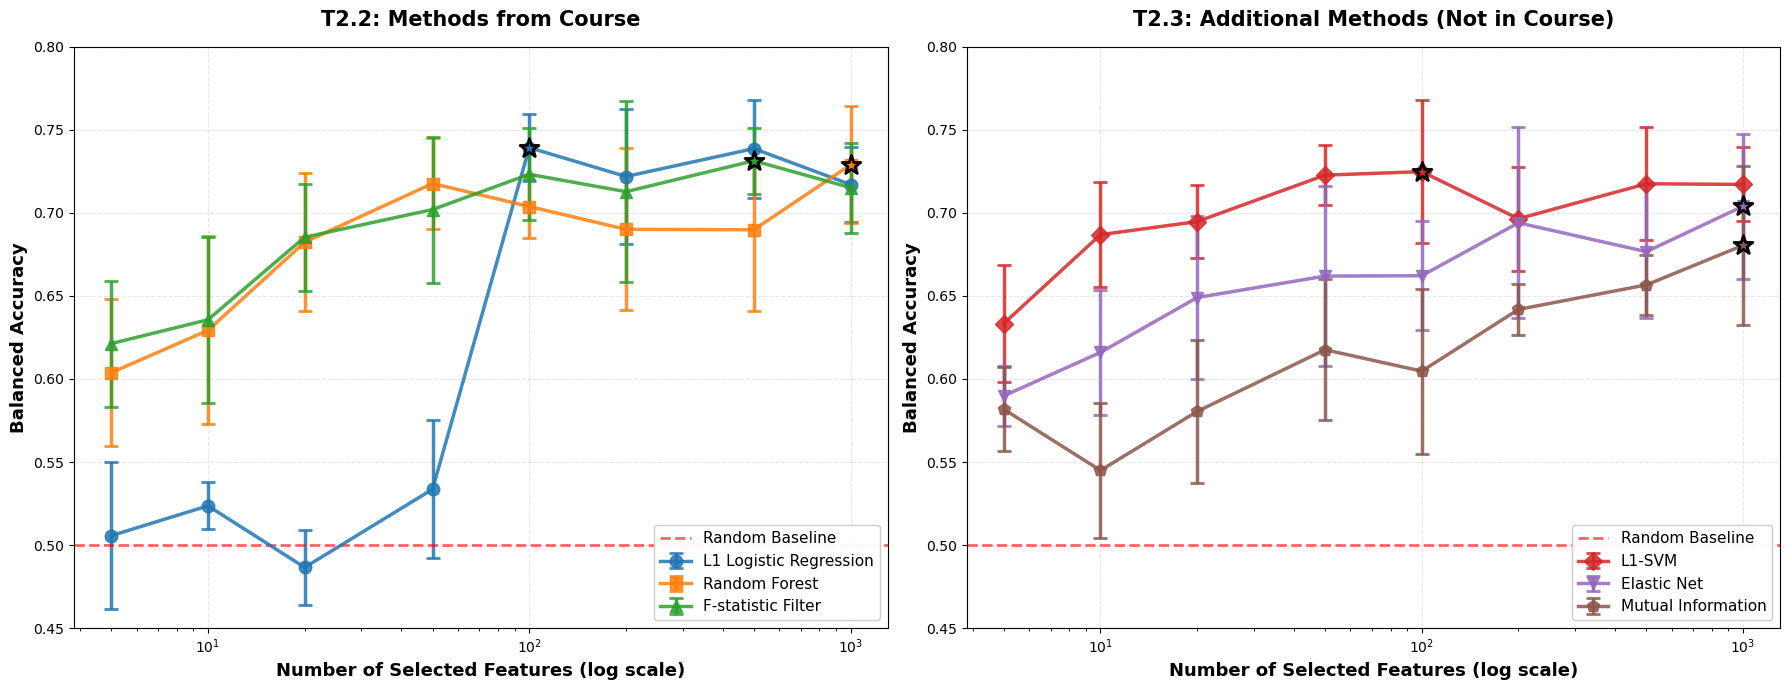

In [8]:
#############################################################################
# PLOT 1: Side-by-Side Comparison
#############################################################################

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ============= LEFT PLOT: T2.2 Methods =============
ax1 = axes[0]

ax1.errorbar(l1_df['n_features'], l1_df['bal_acc'], yerr=l1_df['std'], 
             marker='o', markersize=9, label='L1 Logistic Regression', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.85, color='#1f77b4')
ax1.errorbar(rf_df['n_features'], rf_df['bal_acc'], yerr=rf_df['std'], 
             marker='s', markersize=9, label='Random Forest', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.85, color='#ff7f0e')
ax1.errorbar(fstat_df['n_features'], fstat_df['bal_acc'], yerr=fstat_df['std'], 
             marker='^', markersize=9, label='F-statistic Filter', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.85, color='#2ca02c')

ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
            label='Random Baseline', alpha=0.6)

# Annotate best points
for df, color, name in [(l1_df, '#1f77b4', 'L1'), 
                         (rf_df, '#ff7f0e', 'RF'), 
                         (fstat_df, '#2ca02c', 'F-stat')]:
    best_idx = df['bal_acc'].idxmax()
    best_k = df.loc[best_idx, 'n_features']
    best_acc = df.loc[best_idx, 'bal_acc']
    ax1.scatter(best_k, best_acc, s=200, marker='*', 
                color=color, edgecolor='black', linewidth=2, zorder=5)

ax1.set_xscale('log')
ax1.set_xlabel('Number of Selected Features (log scale)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('T2.2: Methods from Course', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0.45, 0.80)

# ============= RIGHT PLOT: T2.3 Methods =============
ax2 = axes[1]

ax2.errorbar(l1_svm_df['n_features'], l1_svm_df['bal_acc'], yerr=l1_svm_df['std'], 
             marker='D', markersize=9, label='L1-SVM', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.85, color='#d62728')
ax2.errorbar(elastic_df['n_features'], elastic_df['bal_acc'], yerr=elastic_df['std'], 
             marker='v', markersize=9, label='Elastic Net', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.85, color='#9467bd')
ax2.errorbar(mi_df['n_features'], mi_df['bal_acc'], yerr=mi_df['std'], 
             marker='p', markersize=9, label='Mutual Information', 
             capsize=5, linewidth=2.5, capthick=2, alpha=0.85, color='#8c564b')

ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
            label='Random Baseline', alpha=0.6)

# Annotate best points
for df, color, name in [(l1_svm_df, '#d62728', 'SVM'), 
                         (elastic_df, '#9467bd', 'Elastic'), 
                         (mi_df, '#8c564b', 'MI')]:
    best_idx = df['bal_acc'].idxmax()
    best_k = df.loc[best_idx, 'n_features']
    best_acc = df.loc[best_idx, 'bal_acc']
    ax2.scatter(best_k, best_acc, s=200, marker='*', 
                color=color, edgecolor='black', linewidth=2, zorder=5)

ax2.set_xscale('log')
ax2.set_xlabel('Number of Selected Features (log scale)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
ax2.set_title('T2.3: Additional Methods (Not in Course)', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0.45, 0.80)

plt.tight_layout()

# Save
try:
    plt.savefig('task2_side_by_side.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: task2_side_by_side.png")
except:
    print("✗ Could not save figure")

plt.show()

✗ Could not save figure


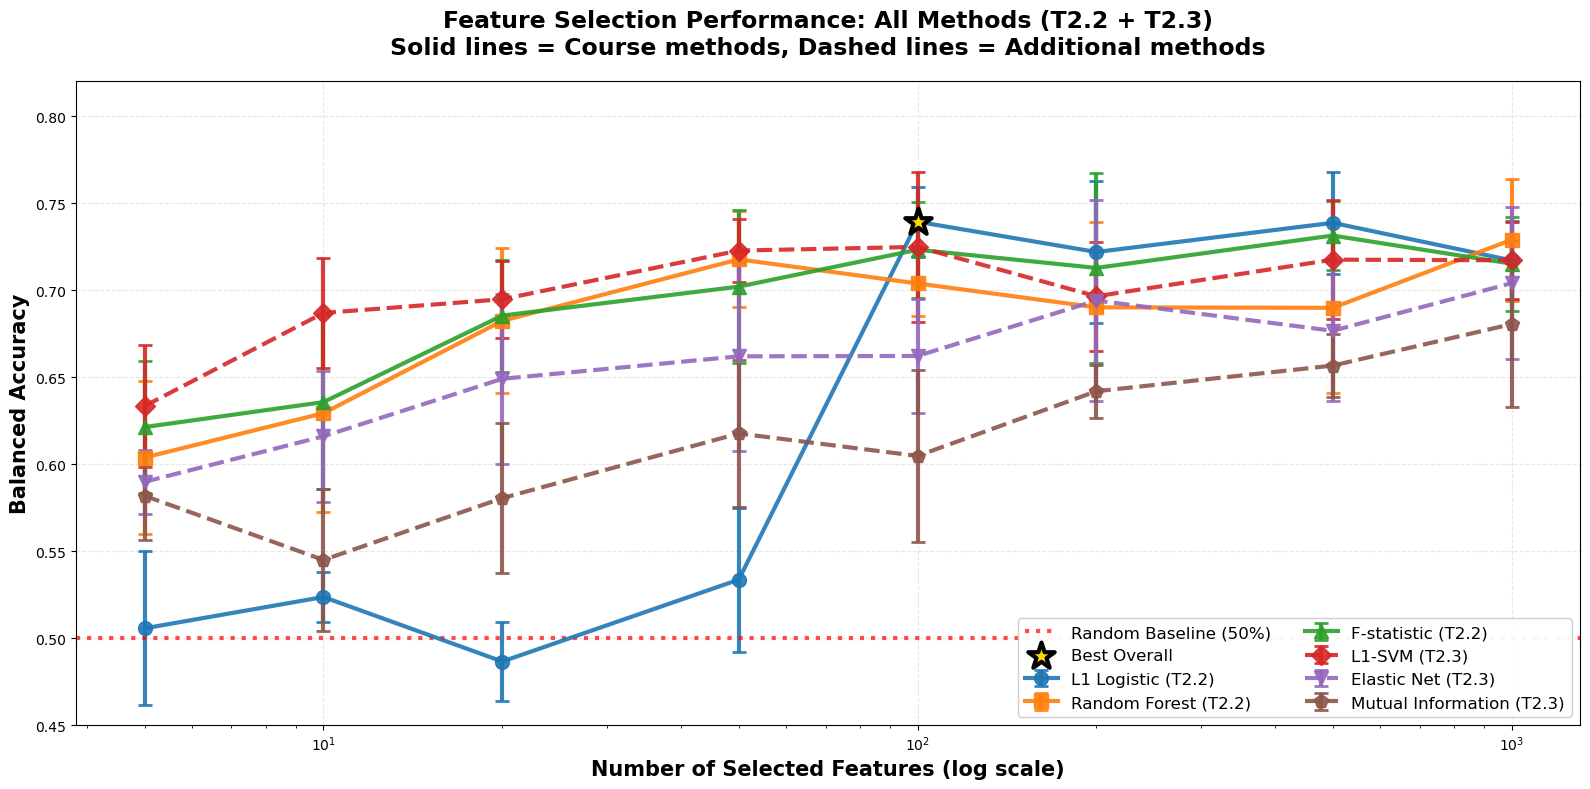

In [9]:
#############################################################################
# PLOT 2: All Methods in One Plot
#############################################################################

plt.figure(figsize=(16, 8))

# T2.2 methods (solid lines, blue tones)
plt.errorbar(l1_df['n_features'], l1_df['bal_acc'], yerr=l1_df['std'], 
             marker='o', markersize=10, label='L1 Logistic (T2.2)', 
             capsize=5, linewidth=3, capthick=2, linestyle='-', 
             alpha=0.9, color='#1f77b4')

plt.errorbar(rf_df['n_features'], rf_df['bal_acc'], yerr=rf_df['std'], 
             marker='s', markersize=10, label='Random Forest (T2.2)', 
             capsize=5, linewidth=3, capthick=2, linestyle='-', 
             alpha=0.9, color='#ff7f0e')

plt.errorbar(fstat_df['n_features'], fstat_df['bal_acc'], yerr=fstat_df['std'], 
             marker='^', markersize=10, label='F-statistic (T2.2)', 
             capsize=5, linewidth=3, capthick=2, linestyle='-', 
             alpha=0.9, color='#2ca02c')

# T2.3 methods (dashed lines, red/purple tones)
plt.errorbar(l1_svm_df['n_features'], l1_svm_df['bal_acc'], yerr=l1_svm_df['std'], 
             marker='D', markersize=10, label='L1-SVM (T2.3)', 
             capsize=5, linewidth=3, capthick=2, linestyle='--', 
             alpha=0.9, color='#d62728')

plt.errorbar(elastic_df['n_features'], elastic_df['bal_acc'], yerr=elastic_df['std'], 
             marker='v', markersize=10, label='Elastic Net (T2.3)', 
             capsize=5, linewidth=3, capthick=2, linestyle='--', 
             alpha=0.9, color='#9467bd')

plt.errorbar(mi_df['n_features'], mi_df['bal_acc'], yerr=mi_df['std'], 
             marker='p', markersize=10, label='Mutual Information (T2.3)', 
             capsize=5, linewidth=3, capthick=2, linestyle='--', 
             alpha=0.9, color='#8c564b')

# Baseline
plt.axhline(y=0.5, color='red', linestyle=':', linewidth=3, 
            label='Random Baseline (50%)', alpha=0.7)

# Highlight best overall performer
all_methods = [l1_df, rf_df, fstat_df, l1_svm_df, elastic_df, mi_df]
best_overall_acc = max([df['bal_acc'].max() for df in all_methods])
for df in all_methods:
    if df['bal_acc'].max() == best_overall_acc:
        best_idx = df['bal_acc'].idxmax()
        best_k = df.loc[best_idx, 'n_features']
        plt.scatter(best_k, best_overall_acc, s=400, marker='*', 
                   color='gold', edgecolor='black', linewidth=3, 
                   zorder=10, label='Best Overall')
        break

plt.xscale('log')
plt.xlabel('Number of Selected Features (log scale)', fontsize=15, fontweight='bold')
plt.ylabel('Balanced Accuracy', fontsize=15, fontweight='bold')
plt.title('Feature Selection Performance: All Methods (T2.2 + T2.3)\n' + 
          'Solid lines = Course methods, Dashed lines = Additional methods',
          fontsize=17, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='lower right', framealpha=0.95, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0.45, 0.82)
plt.tight_layout()

# Save
try:
    plt.savefig('task2_all_methods_combined.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: task2_all_methods_combined.png")
except:
    print("✗ Could not save figure")

plt.show()

✗ Could not save figure


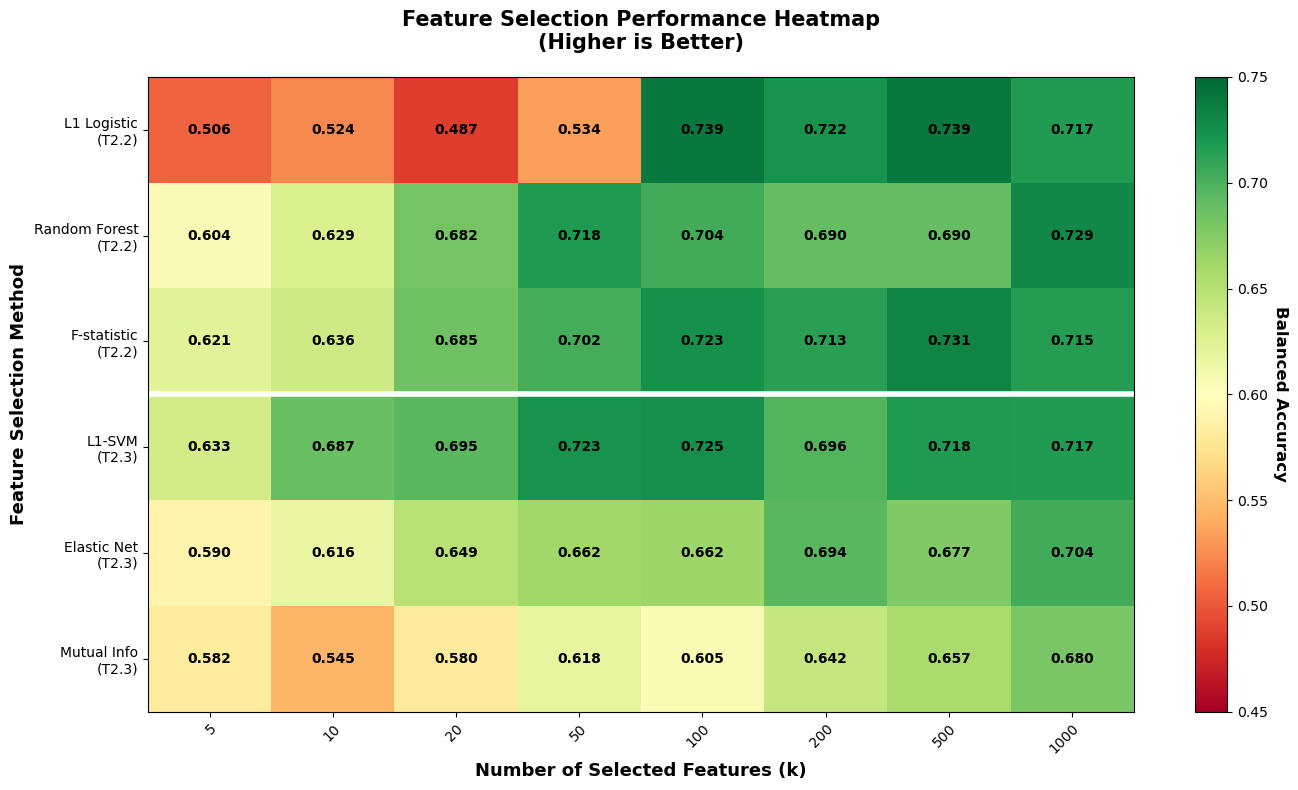

In [10]:
#############################################################################
# PLOT 4: Heatmap of Performance
#############################################################################

# Prepare data for heatmap
methods = ['L1 Logistic\n(T2.2)', 'Random Forest\n(T2.2)', 'F-statistic\n(T2.2)', 
           'L1-SVM\n(T2.3)', 'Elastic Net\n(T2.3)', 'Mutual Info\n(T2.3)']
data_matrix = np.array([
    l1_df['bal_acc'].values,
    rf_df['bal_acc'].values,
    fstat_df['bal_acc'].values,
    l1_svm_df['bal_acc'].values,
    elastic_df['bal_acc'].values,
    mi_df['bal_acc'].values
])

fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap
im = ax.imshow(data_matrix, cmap='RdYlGn', aspect='auto', vmin=0.45, vmax=0.75)

# Set ticks
ax.set_xticks(np.arange(len(feature_counts)))
ax.set_yticks(np.arange(len(methods)))
ax.set_xticklabels(feature_counts)
ax.set_yticklabels(methods)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(methods)):
    for j in range(len(feature_counts)):
        text = ax.text(j, i, f'{data_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Balanced Accuracy', rotation=-90, va="bottom", fontsize=12, fontweight='bold')

# Labels and title
ax.set_xlabel('Number of Selected Features (k)', fontsize=13, fontweight='bold')
ax.set_ylabel('Feature Selection Method', fontsize=13, fontweight='bold')
ax.set_title('Feature Selection Performance Heatmap\n(Higher is Better)', 
             fontsize=15, fontweight='bold', pad=20)

# Add dividing line between T2.2 and T2.3
ax.axhline(y=2.5, color='white', linewidth=4)

plt.tight_layout()

# Save
try:
    plt.savefig('task2_heatmap.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: task2_heatmap.png")
except:
    print("✗ Could not save figure")

plt.show()

✗ Could not save figure


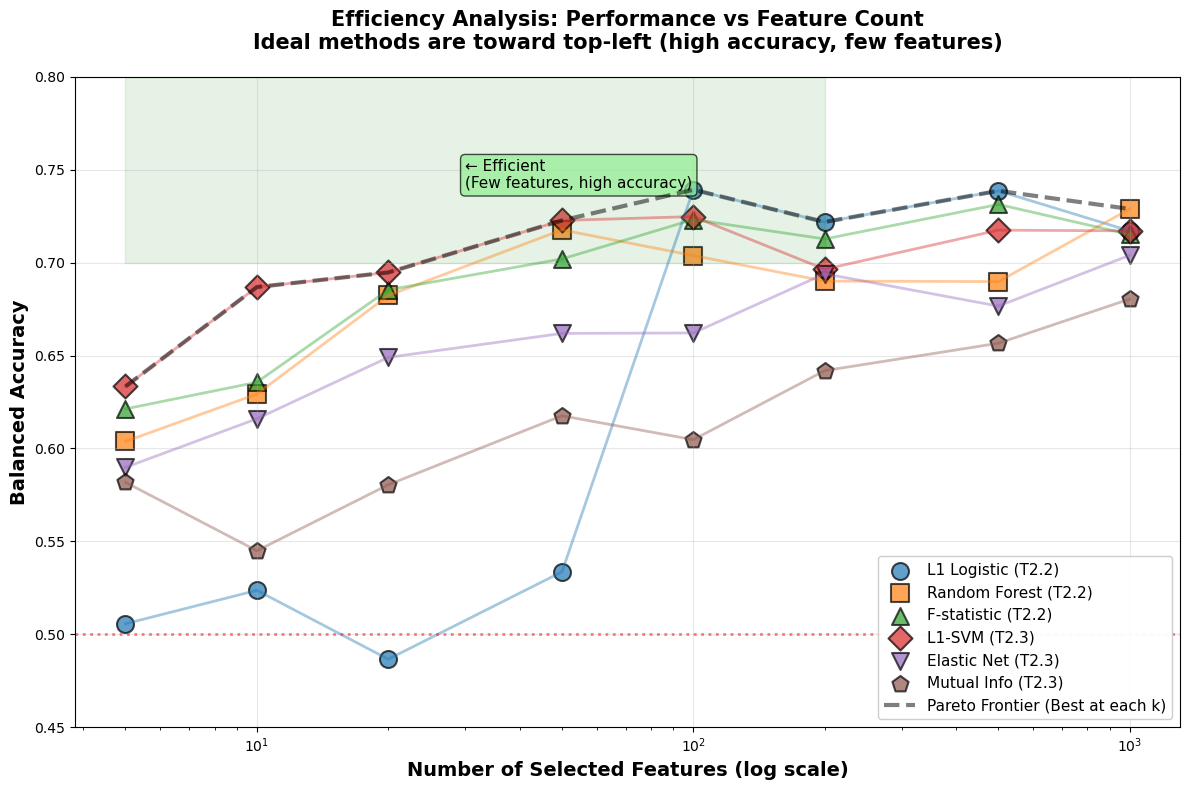

In [11]:
#############################################################################
# PLOT 6: Efficiency - Performance per Feature
#############################################################################

fig, ax = plt.subplots(figsize=(12, 8))

# Calculate efficiency: balanced accuracy / log(k)
for df, marker, label, color in [
    (l1_df, 'o', 'L1 Logistic (T2.2)', '#1f77b4'),
    (rf_df, 's', 'Random Forest (T2.2)', '#ff7f0e'),
    (fstat_df, '^', 'F-statistic (T2.2)', '#2ca02c'),
    (l1_svm_df, 'D', 'L1-SVM (T2.3)', '#d62728'),
    (elastic_df, 'v', 'Elastic Net (T2.3)', '#9467bd'),
    (mi_df, 'p', 'Mutual Info (T2.3)', '#8c564b')
]:
    # Plot balanced accuracy vs number of features
    ax.scatter(df['n_features'], df['bal_acc'], 
              s=150, marker=marker, label=label, alpha=0.7, 
              color=color, edgecolor='black', linewidth=1.5)
    
    # Connect points
    ax.plot(df['n_features'], df['bal_acc'], 
           alpha=0.4, color=color, linewidth=2)

# Add Pareto frontier (envelope of best performance)
all_ks = feature_counts
all_best_accs = []
for k in all_ks:
    best_at_k = max([
        l1_df[l1_df['n_features']==k]['bal_acc'].values[0],
        rf_df[rf_df['n_features']==k]['bal_acc'].values[0],
        fstat_df[fstat_df['n_features']==k]['bal_acc'].values[0],
        l1_svm_df[l1_svm_df['n_features']==k]['bal_acc'].values[0],
        elastic_df[elastic_df['n_features']==k]['bal_acc'].values[0],
        mi_df[mi_df['n_features']==k]['bal_acc'].values[0]
    ])
    all_best_accs.append(best_at_k)

ax.plot(all_ks, all_best_accs, 'k--', linewidth=3, alpha=0.5, 
        label='Pareto Frontier (Best at each k)', zorder=10)

ax.axhline(y=0.5, color='red', linestyle=':', linewidth=2, alpha=0.5)

ax.set_xscale('log')
ax.set_xlabel('Number of Selected Features (log scale)', fontsize=14, fontweight='bold')
ax.set_ylabel('Balanced Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Efficiency Analysis: Performance vs Feature Count\n' +
             'Ideal methods are toward top-left (high accuracy, few features)',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.45, 0.80)

# Annotate "efficient" region
ax.fill_between([5, 200], [0.70, 0.70], [0.80, 0.80], 
                alpha=0.1, color='green', label='Efficient Region')
ax.text(30, 0.74, '← Efficient\n(Few features, high accuracy)', 
       fontsize=11, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()

# Save
try:
    plt.savefig('task2_efficiency.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: task2_efficiency.png")
except:
    print("✗ Could not save figure")

plt.show()

✗ Could not save figure


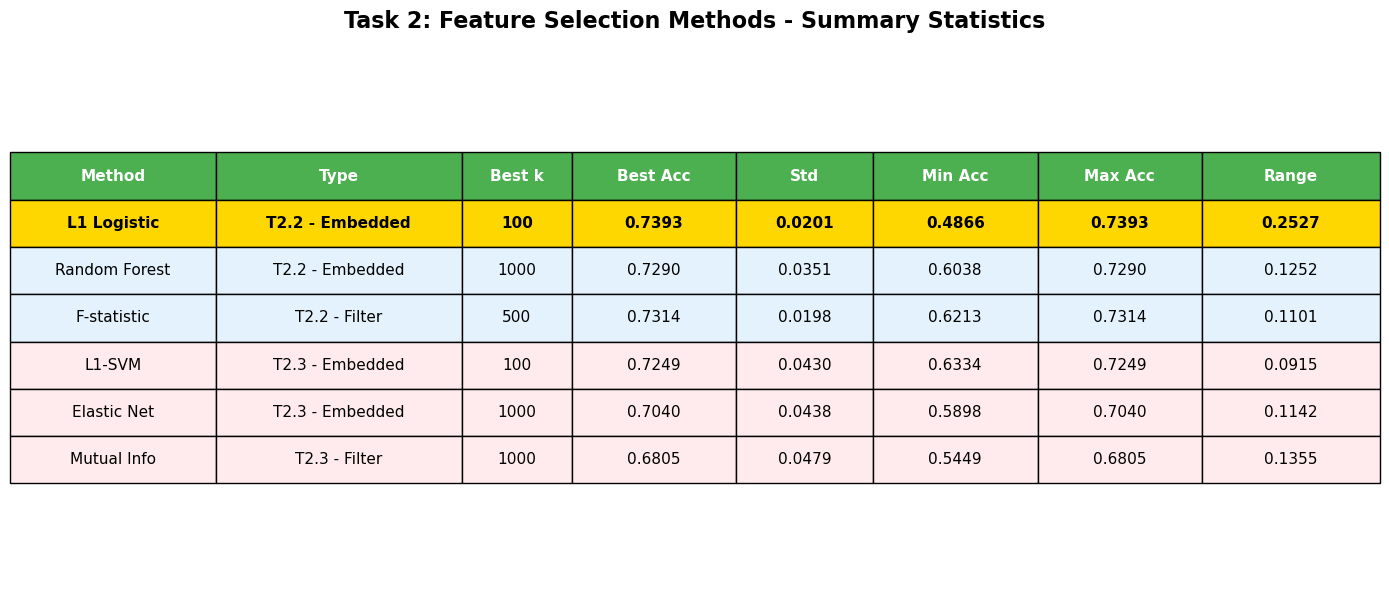

In [12]:
#############################################################################
# PLOT 7: Summary Table as Figure
#############################################################################

fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
table_data.append(['Method', 'Type', 'Best k', 'Best Acc', 'Std', 'Min Acc', 'Max Acc', 'Range'])

for name, df, method_type in [
    ('L1 Logistic', l1_df, 'T2.2 - Embedded'),
    ('Random Forest', rf_df, 'T2.2 - Embedded'),
    ('F-statistic', fstat_df, 'T2.2 - Filter'),
    ('L1-SVM', l1_svm_df, 'T2.3 - Embedded'),
    ('Elastic Net', elastic_df, 'T2.3 - Embedded'),
    ('Mutual Info', mi_df, 'T2.3 - Filter')
]:
    best_idx = df['bal_acc'].idxmax()
    best_k = int(df.loc[best_idx, 'n_features'])
    best_acc = df.loc[best_idx, 'bal_acc']
    best_std = df.loc[best_idx, 'std']
    min_acc = df['bal_acc'].min()
    max_acc = df['bal_acc'].max()
    acc_range = max_acc - min_acc
    
    table_data.append([
        name,
        method_type,
        f'{best_k}',
        f'{best_acc:.4f}',
        f'{best_std:.4f}',
        f'{min_acc:.4f}',
        f'{max_acc:.4f}',
        f'{acc_range:.4f}'
    ])

# Create table
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.15, 0.18, 0.08, 0.12, 0.10, 0.12, 0.12, 0.13])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(len(table_data[0])):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white')

# Style T2.2 rows (light blue)
for i in [1, 2, 3]:
    for j in range(len(table_data[0])):
        table[(i, j)].set_facecolor('#E3F2FD')

# Style T2.3 rows (light red)
for i in [4, 5, 6]:
    for j in range(len(table_data[0])):
        table[(i, j)].set_facecolor('#FFEBEE')

# Highlight best overall
best_overall_idx = np.argmax([float(row[3]) for row in table_data[1:]]) + 1
for j in range(len(table_data[0])):
    table[(best_overall_idx, j)].set_facecolor('#FFD700')
    table[(best_overall_idx, j)].set_text_props(weight='bold')

ax.set_title('Task 2: Feature Selection Methods - Summary Statistics',
            fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()

# Save
try:
    plt.savefig('task2_summary_table.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: task2_summary_table.png")
except:
    print("✗ Could not save figure")

plt.show()

✗ Could not save figure


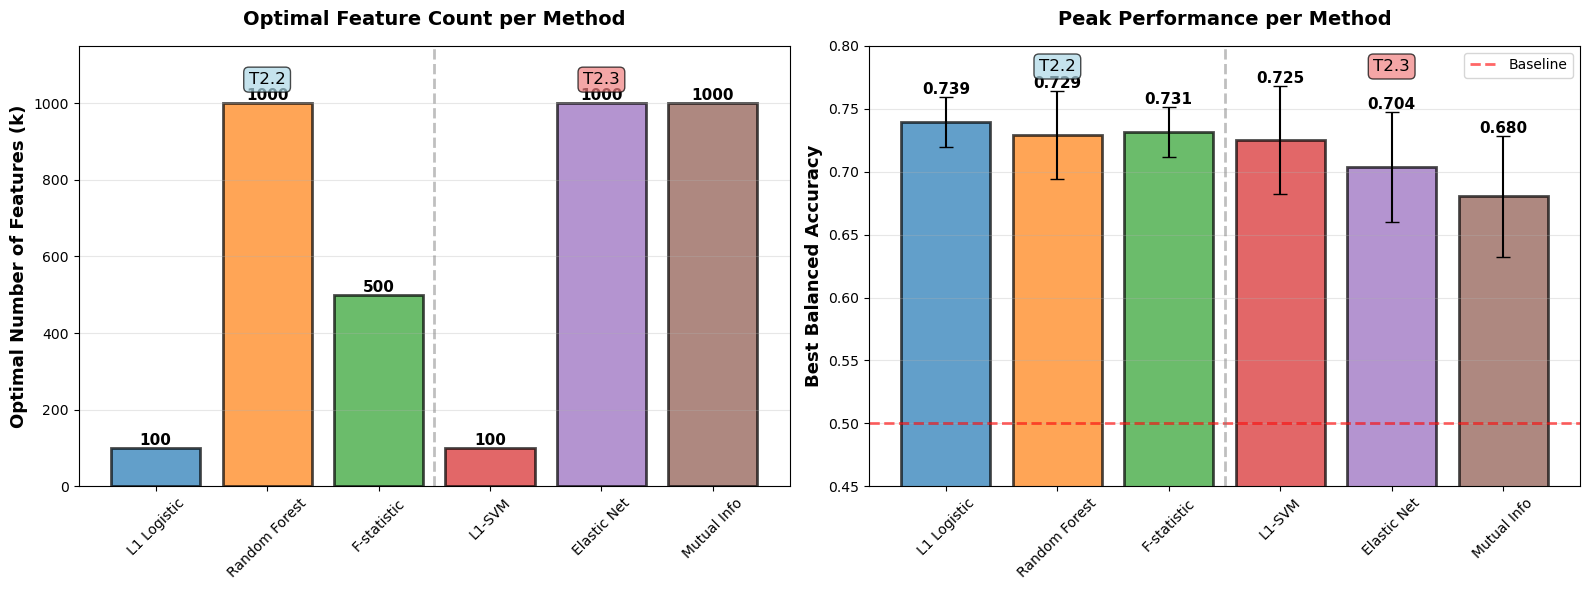

In [13]:
#############################################################################
# PLOT 5: Optimal Number of Features per Method
#############################################################################

# Extract best k and performance for each method
method_names = ['L1 Logistic', 'Random Forest', 'F-statistic', 
                'L1-SVM', 'Elastic Net', 'Mutual Info']
best_ks = []
best_accs = []
best_stds = []
colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for df in [l1_df, rf_df, fstat_df, l1_svm_df, elastic_df, mi_df]:
    best_idx = df['bal_acc'].idxmax()
    best_ks.append(df.loc[best_idx, 'n_features'])
    best_accs.append(df.loc[best_idx, 'bal_acc'])
    best_stds.append(df.loc[best_idx, 'std'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ============= LEFT: Best k for each method =============
bars1 = ax1.bar(method_names, best_ks, color=colors_list, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, k) in enumerate(zip(bars1, best_ks)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(k)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Optimal Number of Features (k)', fontsize=13, fontweight='bold')
ax1.set_title('Optimal Feature Count per Method', fontsize=14, fontweight='bold', pad=15)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(best_ks) * 1.15)

# Add dividing line between T2.2 and T2.3
ax1.axvline(x=2.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax1.text(1, max(best_ks) * 1.05, 'T2.2', ha='center', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax1.text(4, max(best_ks) * 1.05, 'T2.3', ha='center', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# ============= RIGHT: Best accuracy for each method =============
bars2 = ax2.bar(method_names, best_accs, yerr=best_stds, 
               color=colors_list, alpha=0.7, edgecolor='black', linewidth=2,
               capsize=5)

# Add value labels on bars
for i, (bar, acc, std) in enumerate(zip(bars2, best_accs, best_stds)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std,
            f'{acc:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Baseline')
ax2.set_ylabel('Best Balanced Accuracy', fontsize=13, fontweight='bold')
ax2.set_title('Peak Performance per Method', fontsize=14, fontweight='bold', pad=15)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0.45, 0.80)
ax2.legend()

# Add dividing line between T2.2 and T2.3
ax2.axvline(x=2.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax2.text(1, 0.78, 'T2.2', ha='center', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax2.text(4, 0.78, 'T2.3', ha='center', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()

# Save
try:
    plt.savefig('task2_best_performance.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: task2_best_performance.png")
except:
    print("✗ Could not save figure")

plt.show()